In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

sys.path.append('../')

In [17]:
from src.models import TabularTransformer

In [11]:
data = pd.read_csv('../data/data.csv')

In [12]:
data['cat3']=data['cat3'].apply(lambda x: f"cat_3_val_{x}")
data['cat2']=data['cat2'].apply(lambda x: f"cat_2_val_{x}")
data['target']=np.random.randint(0,2, size=(data.shape[0],1))

# data['target']=np.linspace(-10, 10, data.shape[0])


In [13]:
X = data.drop(columns=['target']).copy()
y = data[['target']].copy()


In [14]:
tt = TabularTransformer()

In [15]:
history = tt.fit(X, y, epochs=1)

2/2 [==============================] - 12s 3s/step - loss: 0.9869 - accuracy: 0.6296 - mean_recall: 0.5000 - mean_precision: nan - multi_class_confusion_matrix: 13.5000 - val_loss: 0.8181 - val_accuracy: 0.6667 - val_mean_recall: 0.7500 - val_mean_precision: 0.7500 - val_multi_class_confusion_matrix: 1.5000


In [9]:
tt.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cont1 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 cont2 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 cat1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 cat2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

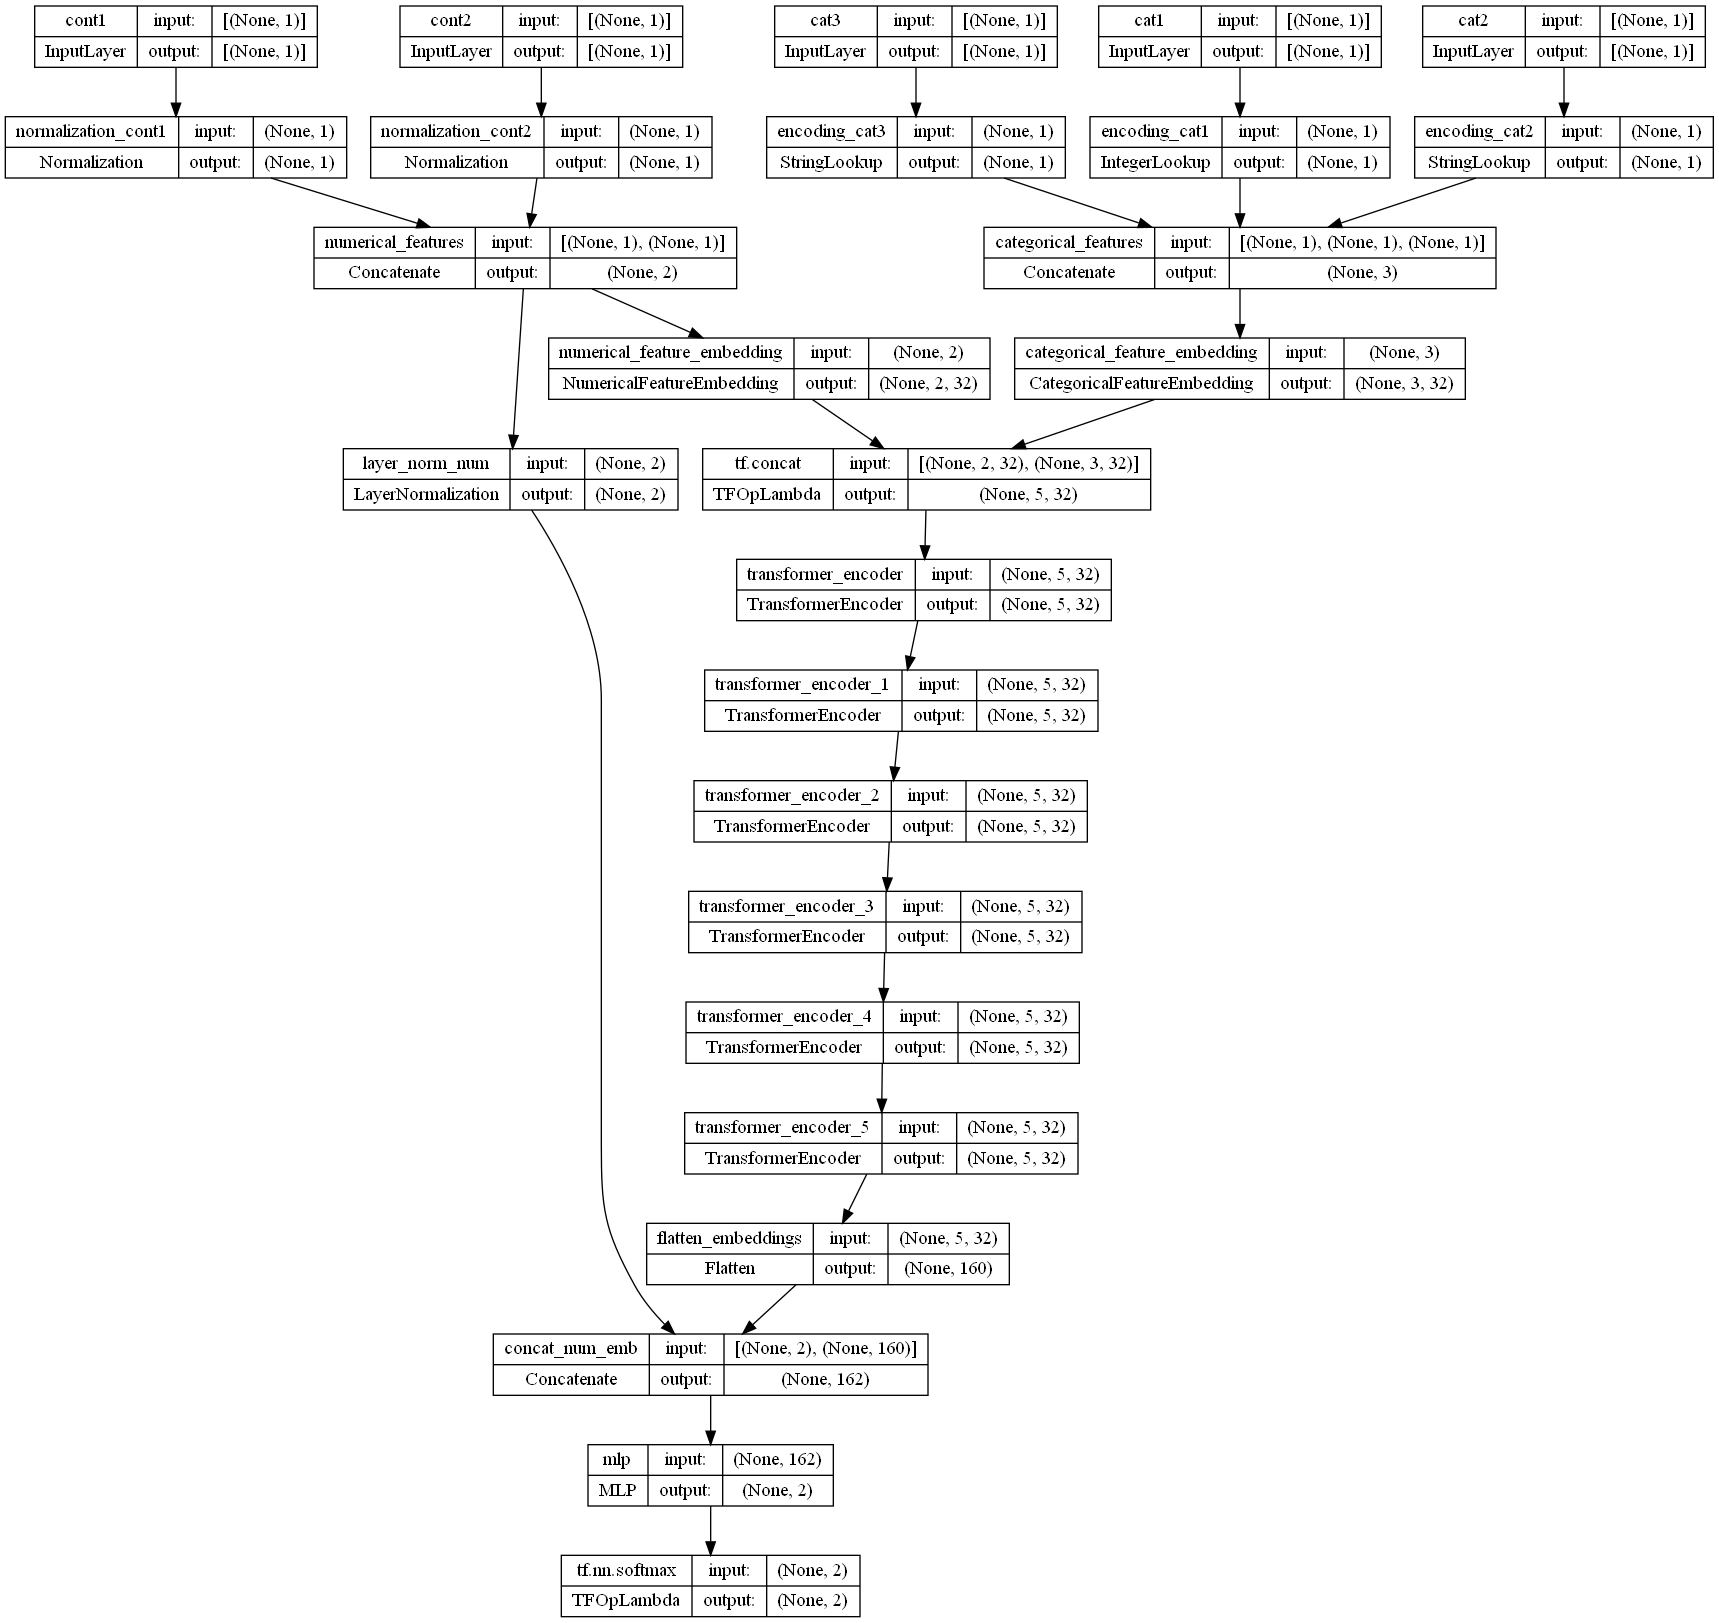

In [16]:
tf.keras.utils.plot_model(tt.model, 
    to_file='../data/model.png',
    show_shapes=True
)

In [11]:
tt.predict(X.sample(10))

1/1 [==============================] - 1s 996ms/step


array([[0.94776195, 0.05223801],
       [0.5078308 , 0.49216917],
       [0.78856707, 0.21143287],
       [0.80087763, 0.19912235],
       [0.89209276, 0.10790724],
       [0.47025526, 0.5297447 ],
       [0.58547574, 0.41452426],
       [0.62069476, 0.3793052 ],
       [0.80271316, 0.1972868 ],
       [0.72093844, 0.2790616 ]], dtype=float32)

In [12]:
tt.evaluate(X.iloc[:20], y.iloc[:20])

1/1 [==============================] - 0s 18ms/step - loss: 0.8064 - accuracy: 0.6000


[0.8064411282539368, 0.6000000238418579]